In this notebook we are creating a NN and backpropagation from scratch baed on https://github.com/karpathy/micrograd

In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def f(x):
    return 3*x**2 - 4*x + 5

In [17]:
f(3.0)

20.0

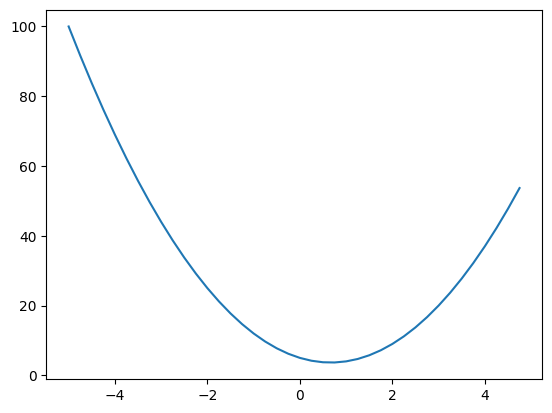

In [18]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [19]:
# what is derivative of f(x) at x=3.0
# derative measures the slope of the response when there is small change in the input
# it teslls us whether slope goes up or doe at that point after the change
# let's say change h is very very small like 0.0001
h = 0.001
x = 3.0
f(x+h)
# at x=3.0 the slope is positive
(f(x+h) - f(x))/h # divide by the change to get the slope
# output 14.00300000000243
#now make the change very very small
h = 0.00000001
(f(x+h) - f(x))/h
#output is 14.00000009255109
# now make the x negative
x = -3.0
(f(x+h) - f(x))/h
#slope is negative
# output is -22.00000039920269

-22.00000039920269

In [20]:
# get a bit more complex more variables 
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [21]:
# let look at the derivative of the above function with respect to a,b,c
h = 0.001

#inputs
d1 = a*b + c
#a = a + h ##d2 will be slightly lower than d1, since we bumped a up by h but b is negative

# now lets bump the b up by h
#b += h # d2 will be slightly higher than d1, since we bumped b up by h and it makes postiive change

# now lets bump the c up by h
c += h # d2 will be slightly higher than d1, since we bumped c up by h and it makes postiive change

d2 = a*b + c 

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


## Neural Network
NN are massive mathematical expressions and we need a data structure to maintain those expressions.
so we build a value object

In [22]:
# a container to represent the value object
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

a = Value(5.0)
a

Value(data=5.0)

In [23]:
# how about adding two value objects
# it will throw an error, since python does not know how to add two value objects
a = Value(5.0)
b = Value(3.0)
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [ ]:
# we define the add method to add two value objects
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a + b

# now add multuplication
a * b

a.__mul__(b).__add__(c)
# we can also by objects
a * b + c 


Value(data=4.0)

In [ ]:
# now let add a structure to keep track of what value produces what resutls
# this is to get the DAG
class Value:
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other))
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other))


a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
print(d)
print(d._prev)

Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}


In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [27]:
# now let's add name of operation that created the output
class Value:
    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

In [ ]:
d._op  

'+'

In [31]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [25]:
# visualise the DAG
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create rectangualr representation of the node
        dot.node(name = uid, label= "{data %0.4f }" % (n.data,  ), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    for n1,n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot


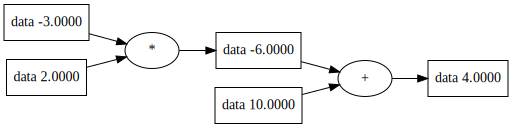

In [29]:
draw_dot(a*b+c)

In [39]:
# now let's add labels
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d
# now let make a layer deep and make out f
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [33]:
# visualise the DAG
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create rectangualr representation of the node
        dot.node(name = uid, label= "{%s | data %0.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    for n1,n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot


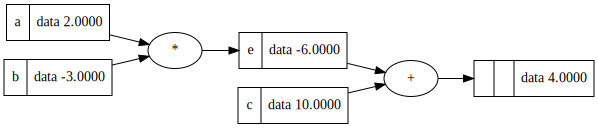

In [34]:
draw_dot(d)

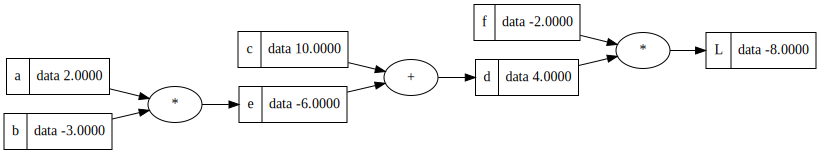

In [40]:
draw_dot(L)

In [42]:
# in NN, L is the loss function, we want to find the derivative of L with respect to a,b,c,d,e,f
# this deraovative is called gradient, stored in variable grad
# now let's add labels
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d
# now let make a layer deep and make out f
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

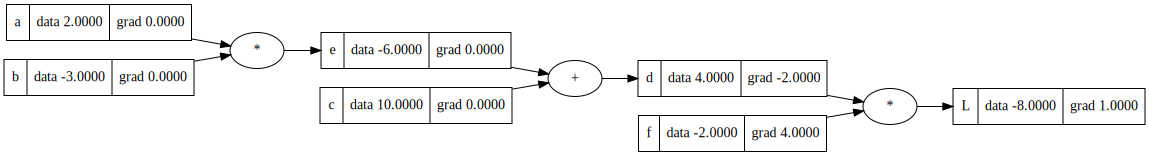

In [51]:
# add grad in visualisation
# visualise the DAG
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create rectangualr representation of the node
        dot.node(name = uid, label= "{%s | data %0.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    for n1,n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot
draw_dot(L)


L = d* f
dL / dd =? f
definition of derative is:
(f(x+h) - f(x))/h
replace d with d+h
((d+h)*f - d* f)/h
(d*f + h*f - d*f)/h
f

**The '+' operator is local gradient that just passses the information without any change. Change happens with "*" operator**

How L is sensitive to c?
via chain rule

dd / dc ?
d = c + e

definition of derative is:
(f(x+h) - f(x))/h

((c+h + e) - (c+e))/h
(c+h+e-c-e)/h
h/h = 1.0

similarly 
dd /de = 1.0

This is local derative with the + node

WANRT:
dL / dc

KNOW:
dL / dd
dd /dc

By chain rule

dL / dc = (dL / dd) * (dd /dc)




In [52]:
#L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = -2.0
e.grad = -2.0

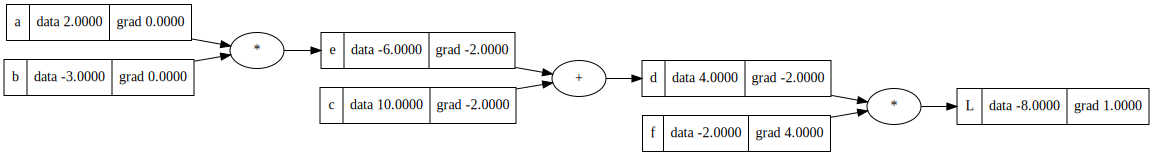

In [53]:
draw_dot(L)

Now applying chain rule all the way back to start of the above graph

dL / de = -2.0

dL /da = (dL / de) * (de / da)


In [ ]:
a.grad = b.data * e.grad
b.grad = a.data * e.grad

In [56]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  e.data += h
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()


-2.000000000000668


### Backpropagation
It is the recursive application of chain rule backwards through the computation graph
Use chain-rule to find the derative of oeprators that are one or moe step away

SUmmarised chain rule is: " if a  car travels twice as fast as a bucylce and bicycle is 4 times as fast as a walking amn, then car travels 2 x 4 = 8 times as fast as the man."

In [57]:
step = 0.01
a.data  += step * a.grad
b.data  += step * b.grad
c.data  += step * c.grad
f.data  += step * f.grad

# forward pass
e = a*b
d = e + c
L = d * f

print(L.data)


-7.800800000000001


### Backpropagation in NN
NN ahve input vector multiplied by weights (synapses) added and passed though an activation function (squashing functions)

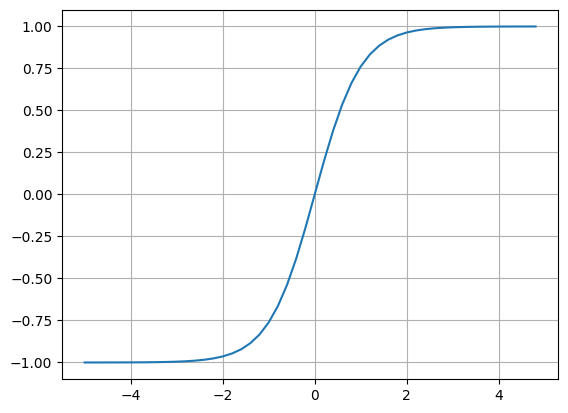

In [58]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

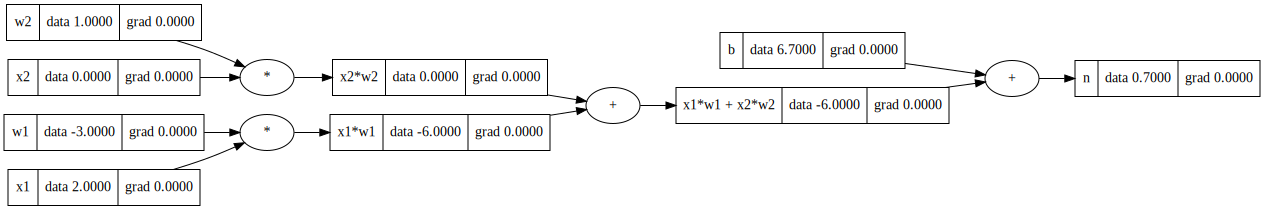

In [61]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
draw_dot(n)

In [74]:
# first implement the sigmoid function in the Value class
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d
# now let make a layer deep and make out f
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [85]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

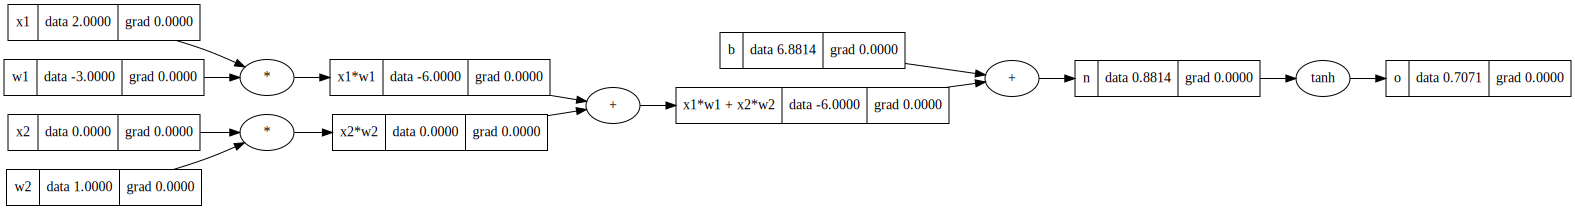

In [76]:
draw_dot(o)

In [77]:
o.grad = 1.0
# o = tanh(h)
#do/dn = 1-o**2 
n.grad = 1-o.data**2

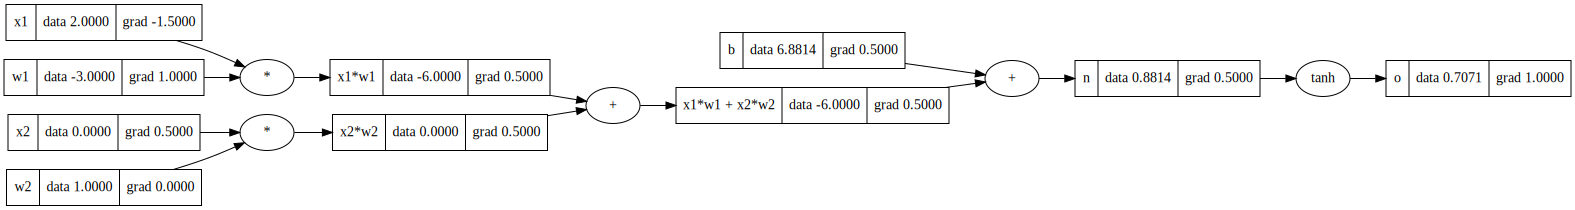

In [80]:
n.grad
# now + operator just distributes the gradient to the children, therefore
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data


draw_dot(o)

In [86]:
# now we update the Value class to include the backward method
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        # + node takes the gradient from the output and distributes it to the children
        # in backpropagation we will call the _backward method to distribute the gradient

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward()
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        # * node takes locla derative and multiplies it otu output gradient
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward()
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward()
        return out
    
    def backward(self):
        self.grad = 1.0
        if self._op == 'tanh':
            self._prev[0].grad = self.grad * (1 - self.data**2)
        else:
            for p in self._prev:
                p.grad += self.grad


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d
# now let make a layer deep and make out f
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [101]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # this is to faciliate adding scalar to Value
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      # += is used to accumulate the gradient otherwise it will be overwritten
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out

  def __rmul__(self, other):
    # python calls this method when the left operand is not a Value object. e.g. 2 * Value(3.0)
    return self.__mul__(other)
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    t = math.exp(x)
    out = Value(t, (self, ), 'exp')
    
    def _backward():
      self.grad += t * out.grad
    out._backward = _backward
    
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only integer or float power is supported"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
  
  def __truediv__(self, other):
    return self * other**-1
  
  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#------
e = (2*n).exp()
o = (e-1) / (e+1); o.label = 'o'
o.backward()
draw_dot(o)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

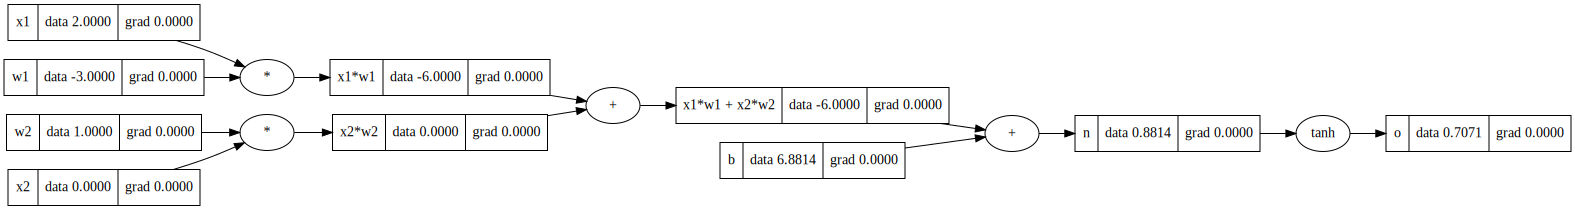

In [95]:
draw_dot(o)

In [98]:
# now no need to set the gradient manually
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [99]:
# instead of calling backward on each node, we will build  a topological order of the nodes and call backward on each node in reverse order
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
o.grad = 1.0


There is bug in the first v esion if the variable is used more than once. so we need to do multivariate backpropagation. therefore we need to accumulate the gradients.


In [102]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

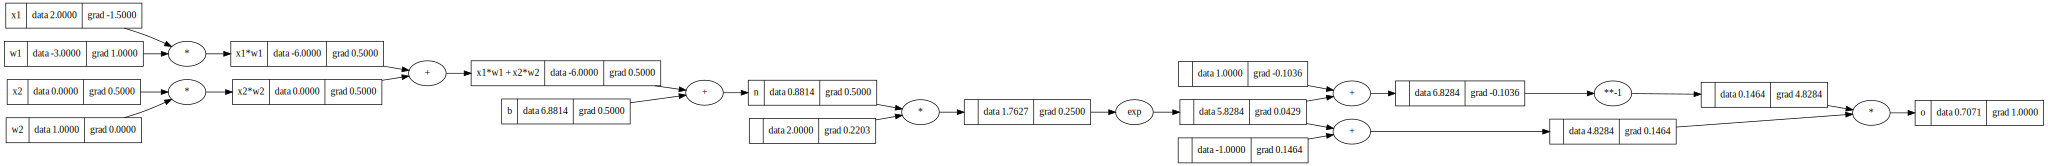

In [103]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#------
e = (2*n).exp()
o = (e-1) / (e+1); o.label = 'o'
o.backward()
draw_dot(o)

## Pytorch

create a class of NN

In [107]:
import torch
import random

In [106]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
 #use double to convert to float64 scalar python by default uses double precision floating point
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [141]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(4, [4, 4, 1]) 
n(x)
    


Value(data=0.331135945379776)

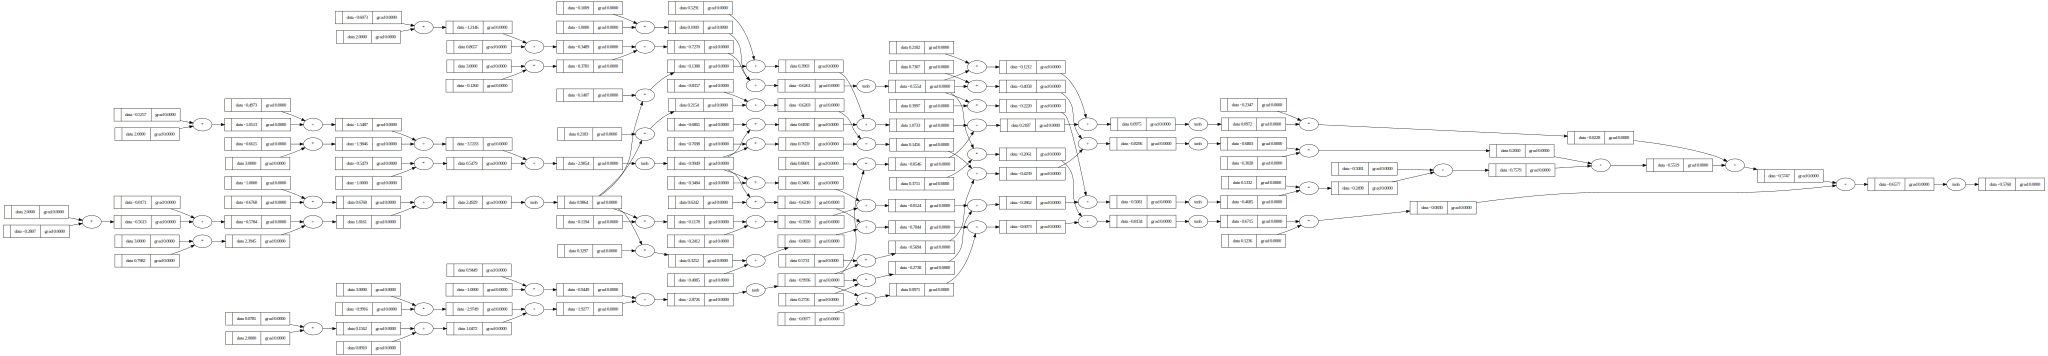

In [110]:
draw_dot(n(x))

In [142]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [127]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9334508934952839),
 Value(data=0.8324120933907729),
 Value(data=0.3433739837148214),
 Value(data=0.8001318374196535)]

In [128]:
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss

Value(data=5.206763806116403)

In [130]:
loss.backward()

In [131]:
n.layers[0].neurons[0].w[0].grad

0.35982430383077163

In [132]:
n.layers[0].neurons[0].w[0].data

-0.22130971179762082

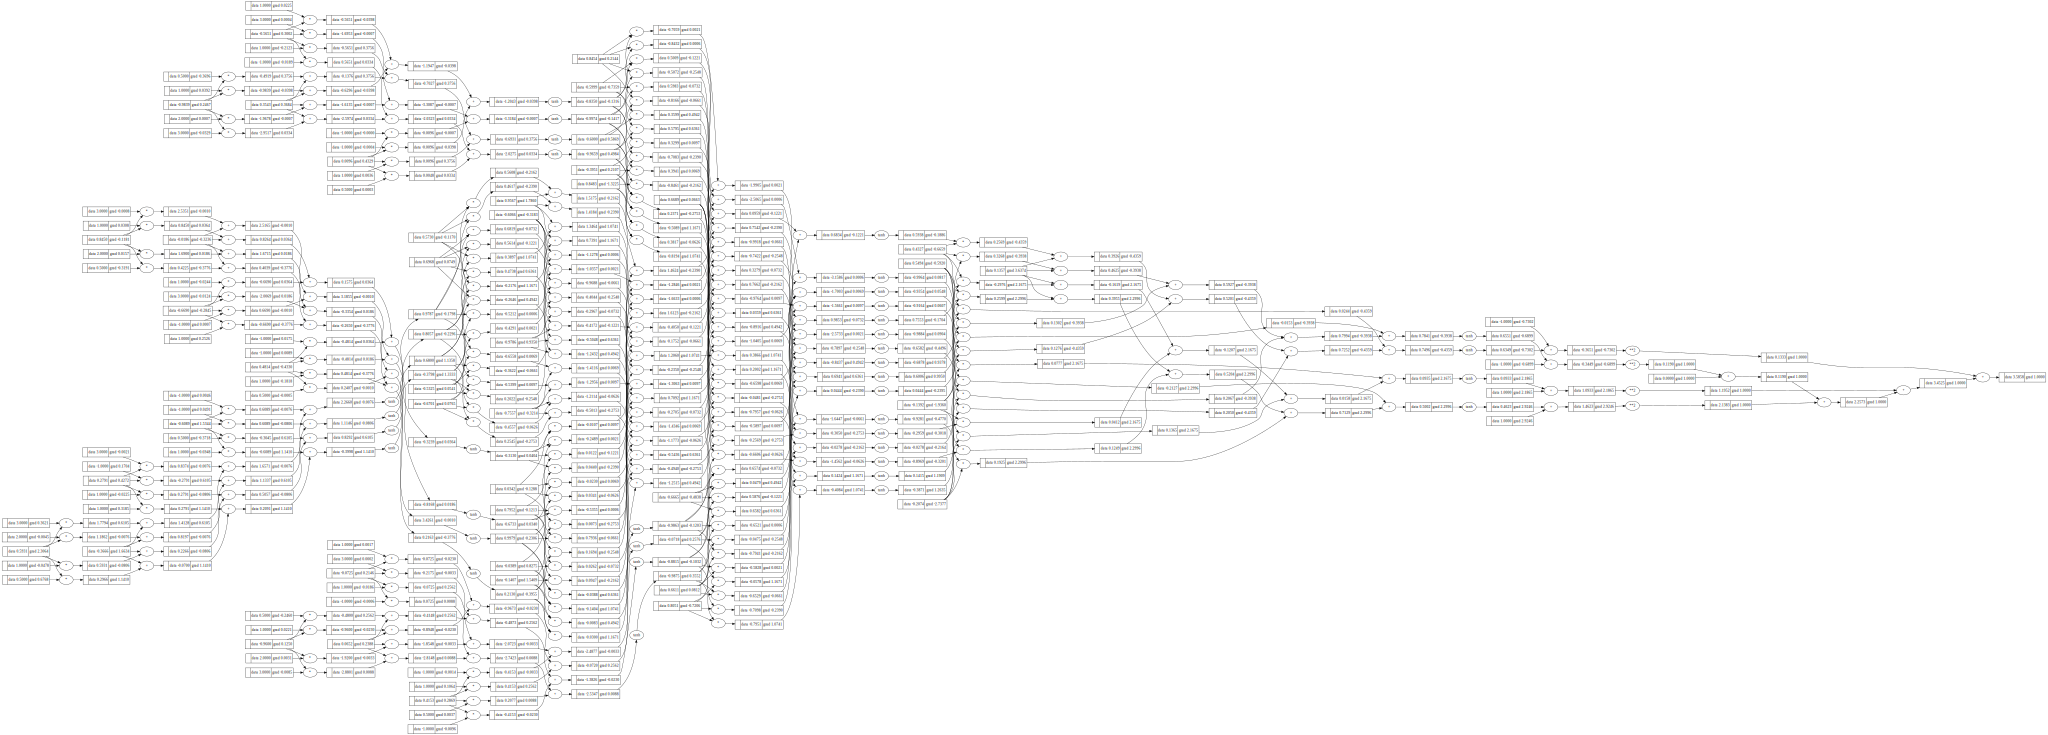

In [124]:
draw_dot(loss)

In [139]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [140]:
n.layers[0].neurons[0].w[0].data

-0.23210444091254398

In [143]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

    #backward pass

    loss.backward()  #this accumulates the gradient in the parameters. so make sure to zero grad

    #update the parameters
    for p in n.parameters():
        p.grad = 0
        p.data += -0.01 * p.grad
    
    print(k, loss.data)
    
        

0 4.046267025526562
1 3.45218283107725
2 2.55444792750413
3 1.7190767136326321
4 1.05002631643845
5 0.5586635358068553
6 0.26424867310108596
7 0.1137602019163598
8 0.044561763693541444
9 0.01615346662126329
10 0.005589317026190768
11 0.001911341983120532
12 0.0006685333812355127
13 0.00024617918033312437
14 9.720081970608622e-05
15 4.1440884319402566e-05
16 1.907189475315052e-05
17 9.448482919101001e-06
18 5.026919639968357e-06
19 2.867800753177625e-06


In [144]:
ypred

[Value(data=0.9987617906561552),
 Value(data=-0.999789529062519),
 Value(data=-0.9997095597868582),
 Value(data=0.9989018265888034)]